# Поиск закономерностей, определяющих успешность игр.
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Этап 1. Изучение общей информации

In [1]:
# Импортируем библиотеки pandas, numpy, matplotlib.pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Импортируем stats из scipy
from scipy import stats as st

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# создаем датафрейм df_games
path = '/content/drive/My Drive/yandex.practicum projects/datasets/4. Test project 1/'

df_games = pd.read_csv(path + 'games.csv')

In [4]:
df_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод этапа 1

На данном этапе мы импортировали необходимые библиотеки и методы, создали датафреймы и ознакомились с ними. По первому взгляду можно сказать, что датафрейм df_games содержит 11 столбцов и 16715 строк, есть пропуски в столбцах Name, Genre, Year_of_Release, Critic_Score, User_Score, Rating. Так же видно, что столбец User_Score имеет тип данных object.

## Этап 2. Подготовка данных

In [6]:
# приведение столбцов df_games к нижнему регистру
df_games.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales',\
                  'critic_score', 'user_score', 'rating']

**Замена типов данных**  
В данной таблице необходимо поменять тип данных столбца df_games['user_score'] с object на float, однако среди оценок так же попадается абревиатура "tbd", которая обозначает что оценок пользователей было поставлено недостаточно, для отображения. При таких обстоятельствах оценки "tbd" можно приравнять к пропускам.  

Так же мы видим, что у столбца с датой релиза игры df_games['year_of_release'] тип данных float. При работе над данным проектом мне было удобнее не менять тип данных данного столбца на datetime и работать с типом данных float.

In [7]:
# преобразование типа данных столбца df_games['user_score'] в тип float.
# Некорректные значения ('tbd') заменяются на NaN
df_games['user_score'] = pd.to_numeric(df_games['user_score'], errors='coerce')

**Пропуски**

In [8]:
# количество пропусков в датафрейме df_games
df_games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Как мы видим, пропуски содержатся в столбцах 'name', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating'.  
- Пропуски в столбцах 'name' и 'genre' находятся в однах строках, что показывает, что скорее всего они взаимосвязаны между собой.
- Пропуски в столбцах 'critic_score' и 'user_score' вероятно связаны с отсутствием данных оценок (у нас нет информации, откуда брали оценки для данных столбцов, так что точно ответить невозможно). Предположим, что часть пропусков из-за отсутствия данных, часть - случайна. Так же часть оценок из столбца 'user_score', которвые имели значение "tbd", мы намеренно заменили на пропуски.
- Пропуски в столбце 'rating' возможно связаны с отсутствием возрастной сертификации у некоторых игр, остальная часть пропусков вероятно случайна. Так, например, у игры "The Elder Scrolls V: Skyrim" есть оценки и рейтинг на платформах X360, PS3 и PC, но нет на платформах PS4 и XOne. Пропуски не зависят от платформы.  
- Пропуски в столбце 'year_of_release' случайны. Я не нашел их зависимость от каких-либо других значений.

In [9]:
# Пример пропусков в столбцах 'critic_score', 'user_score' и 'rating' по одной игре на разных платформах
df_games.query('name == "The Elder Scrolls V: Skyrim"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
75,The Elder Scrolls V: Skyrim,X360,2011.0,Role-Playing,5.05,2.79,0.10,0.85,96.0,8.4,M
130,The Elder Scrolls V: Skyrim,PS3,2011.0,Role-Playing,2.55,2.60,0.25,1.00,92.0,6.4,M
313,The Elder Scrolls V: Skyrim,PC,2011.0,Role-Playing,1.16,2.12,0.00,0.60,94.0,8.1,M
1475,The Elder Scrolls V: Skyrim,PS4,2016.0,Role-Playing,0.48,0.59,0.04,0.21,NaN,NaN,NaN
2768,The Elder Scrolls V: Skyrim,XOne,2016.0,Role-Playing,0.41,0.27,0.00,0.07,NaN,NaN,NaN


В данном проекте можно удалить строки с пропусками в столбцах 'name' и 'genre', однако данные пропуски нам не помешают в проведении исследования, а имеющиеся данные о продажах помогут получить более точные данные о продажах по платформам.  

Возможно было заменить пропуски в столбцах 'critic_score' и 'user_score' для одной игры на платформах с пропусками, опираясь на имеющиеся данные по другим платформам, однако я не считаю данную замену достаточно справедливой, из-за имеющихся различий в оценках на разных платформах. Причину этого я вижу в том, что даже одна и та же игра может ощущаться совершенно по разному на разных платформах, иметь различия в оптимизации, багах, графике и прочих нюансах. Следовательно оценки на разных платформах даже у одой и той же игры могут быть различны. В дальнейшем, при проверке гипотез, мы удалим пропуски из столбца 'user_score'.  
    
Замена пропусков в годах на средней год игр по платформе, на которой вышла игра, несколько исказит график роста и падения популярности платформы. Т.к. пропуски случайны, предположим, что пропуски распределены пропорционально количеству вышедших между годами.

Пропуски в рейгинге ESRB можно было бы заполнить для игр, которые выходили на разных платформах и, логично предположить, имеют одинаковый рейтинг ESRB (например, как игра выше). К сожалению на данный момент я не придумал, как это осуществить.

In [10]:
# Добавление столбца с суммарными продажи во всех регионах
df_games['total_sales'] = df_games['na_sales'] + df_games['eu_sales'] + df_games['jp_sales'] + df_games['other_sales']

### Вывод этапа 2

На данном этапе мы привели столбцы df_games к нижнему регистру, изменили тип данных столбца df_games['user_score'] с object на float, при этом удалили оценку "tbd", которая обозначает что оценок пользователей было поставлено недостаточно, для отображения. Такие оценки были заменены на пропуски. Было описано, почему мы отказались от заполнения пропусков столбцов 'critic_score' и 'user_score'. Также был создан столбец df_games['total_sales'] с суммарными продажами игр во всех регионах.

## Этап 3.  Исследовательский анализ данных

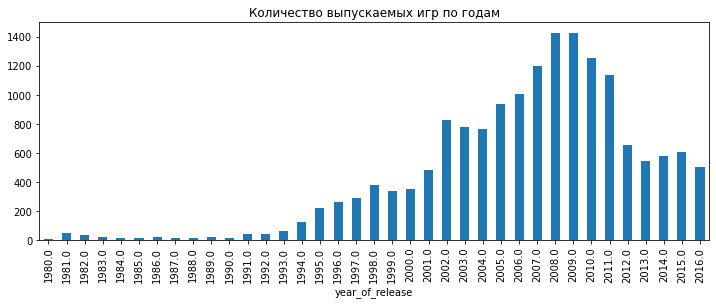

In [11]:
# Количество выпускаемых игр по годам. Для подсчета количества используем любой столбец df_games без пропусков
df_games.\
    pivot_table(index='year_of_release', values='total_sales', aggfunc='count').\
    plot(kind='bar', legend=False, title='Количество выпускаемых игр по годам', figsize=(12,4))
plt.show()

На данном графике видно, что количество выпускаемых игр непрерывно росло с 1990 года. Пиковые значения в 1400 выпущенных игр приходятся на 2008 и 2009 года, после чего мы наблюдаем падение. Количество выпущенных игр значительно упало к 2012 году и до нынешнего момента (конец 2016 года) остается приблизительно на одном уровне.  
Для данного исследования важны данные не за все периоды, а только за последние годы, т.к. игроиндустия является довольно динамичной индустрией и тренды в ней постоянно меняются.  
**Для исследования возьмем данные с 2012 по 2016 годы.**

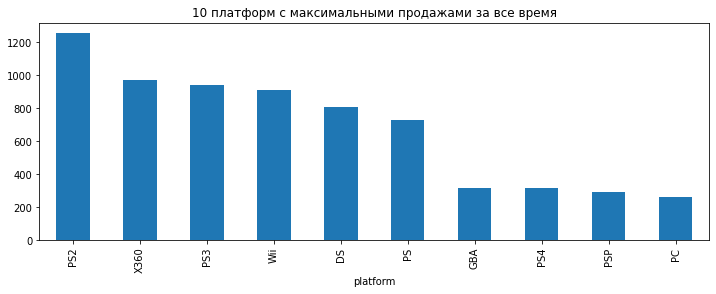

In [12]:
# Продажи по платформам за все время
df_games.pivot_table(index='platform', values='total_sales', aggfunc='sum').\
    sort_values('total_sales', ascending=False).\
    head(10).\
    plot(kind='bar', legend=False, title='10 платформ с максимальными продажами за все время', figsize=(12,4))
plt.show()

Как видно из данного графика - платформами с максимальными продажами являются PS2, X360, PS3, Wii, DS и PS. У остальных платформ продажи заметно ниже.

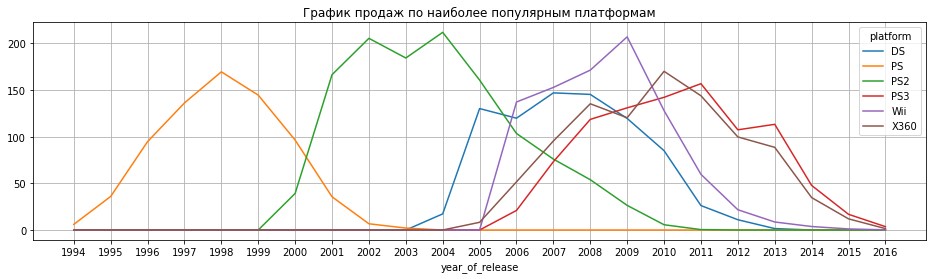

In [13]:
# График продаж по наиболее популярным платформам
# Возьмем первые шесть платформ из предыдущей диаграммы
list_of_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

platform_max_sales = df_games.\
    query('platform == @list_of_platforms').\
    pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').\
    fillna(0)

platform_max_sales.loc[1994:].\
    plot(grid=True,title='График продаж по наиболее популярным платформам',figsize=(16,4))
plt.xticks(np.arange(1994,2017,1))   # У платформы DS имеется ошибочное значение по продажам в 1985 году.
plt.show()                           # Для компактности я беру значения с 1994 года

Как мы видим на данном графике - средний срок жизни наиболее успешных платформ в среднем составляет 10 лет.

In [14]:
# Возьмем данные по выпущенным играм за последние 5 лет (с 2012 по 2016 годы), как нами было определено ранее
df_games_actual = df_games.query('year_of_release >= 2012')

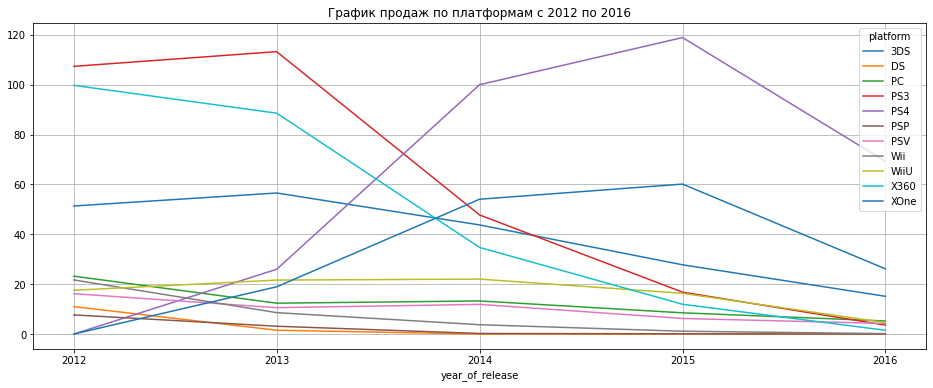

In [15]:
# График продаж по платформам с 2012 по 2016
df_games_actual.\
    pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').\
    fillna(0).\
    plot(grid=True, title='График продаж по платформам с 2012 по 2016', figsize=(16,6))
plt.xticks(np.arange(2012,2017,1))
plt.show()     

Как мы видим, из всех платформ позитивная динамика продаж только у двух - PS4 и XOne. Продажи у остальных платформ падают год к году, из чего можно сделать вывод, что перспективными на данный момент можно считать только PS4 и XOne.  

Так же можно обратить внимание, что продажи за 2016 год меньше, чем продажи за 2015 год, однако это вероятнее всего связано с тем, что игры, вышедшие в 2016 году еще не успели купить все желающие и они приобретут их позднее.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


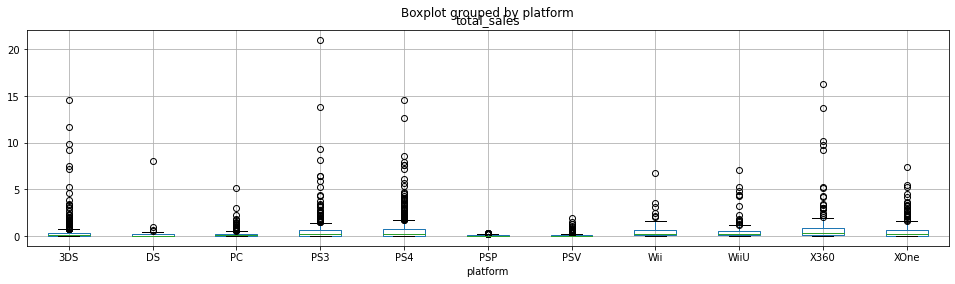

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


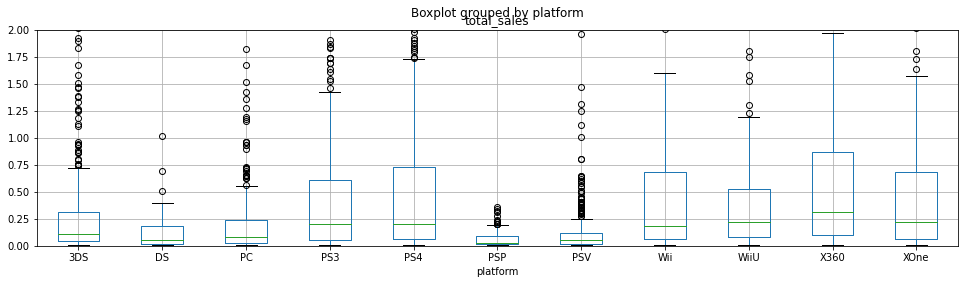

In [16]:
# boxplot по глобальным продажам игр по платформам
df_games_actual.boxplot('total_sales', 'platform', figsize=(16,4))
plt.show()

df_games_actual.boxplot('total_sales', 'platform', figsize=(16,4))
plt.ylim(0,2)
plt.show()

Продажи по разным платформам значительно различиются. Так платформами с наибольшими продажами можно назвать 3DS, PS3, PS4, X360.  
Средние продажи по платформам различаются значительно меньше. Из платформ с наибольшими средними продажами можно выделить PS3, PS4, Wii, WiiU, X360 и XOne.


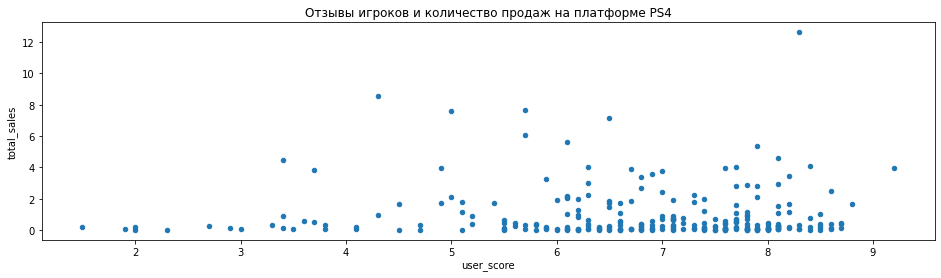

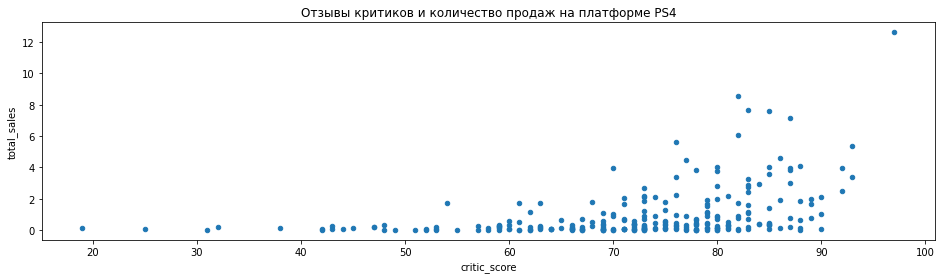

Кореляция оценок игроков и общих продаж составляет -0.03
Кореляция оценок критиков и общих продаж составляет 0.41


In [17]:
# Диаграмма рассеяния отзывов и продаж на платформе PS4
df_games_actual.\
    query('platform == "PS4"').\
    plot(x='user_score', y='total_sales', kind='scatter',
         title='Отзывы игроков и количество продаж на платформе PS4', figsize=(16,4))
df_games_actual.\
    query('platform == "PS4"').\
    plot(x='critic_score', y='total_sales', kind='scatter',
         title='Отзывы критиков и количество продаж на платформе PS4', figsize=(16,4))
plt.show()

# Корреляция между отзывами и продажами на платформе PS4
print('Кореляция оценок игроков и общих продаж составляет {:.2f}'.\
    format(df_games_actual['user_score'][df_games_actual['platform'] == "PS4"].\
    corr(df_games_actual['total_sales'][df_games_actual['platform'] == "PS4"])))
print('Кореляция оценок критиков и общих продаж составляет {:.2f}'.\
    format(df_games_actual['critic_score'][df_games_actual['platform'] == "PS4"].\
      corr(df_games_actual['total_sales'][df_games_actual['platform'] == "PS4"])))

Как мы можем наблюдать, корреляция между отзывами игроков и продажами составляет -0.03, что означает, что она практически отсутствует. Игра с большими продажами может иметь как высокую, как и низкую оценку игроков.   
При этом корреляция между отзывами критиков и продажами составляет 0.41, что говорит о наличии слабой связи. На диаграмме так же видно, что чем выше оценки критиков - тем больше игр с высокими продажами.

In [18]:
# Корреляция между отзывами и продажами на платформе PS3
print('Кореляция оценок игроков и общих продаж платформы PS3 составляет {:.2f}'.\
    format(df_games_actual['user_score'][df_games_actual['platform'] == "PS3"].\
    corr(df_games_actual['total_sales'][df_games_actual['platform'] == "PS3"])))
print('Кореляция оценок критиков и общих продаж платформы PS3 составляет {:.2f}'.\
    format(df_games_actual['critic_score'][df_games_actual['platform'] == "PS3"].\
      corr(df_games_actual['total_sales'][df_games_actual['platform'] == "PS3"])))
print()
# Корреляция между отзывами и продажами на платформе XOne
print('Кореляция оценок игроков и общих продаж платформы XOne составляет {:.2f}'.\
    format(df_games_actual['user_score'][df_games_actual['platform'] == "XOne"].\
    corr(df_games_actual['total_sales'][df_games_actual['platform'] == "XOne"])))
print('Кореляция оценок критиков и общих продаж платформы XOne составляет {:.2f}'.\
    format(df_games_actual['critic_score'][df_games_actual['platform'] == "XOne"].\
      corr(df_games_actual['total_sales'][df_games_actual['platform'] == "XOne"])))
print()
# Корреляция между отзывами и продажами на платформе X360
print('Кореляция оценок игроков и общих продаж платформы X360 составляет {:.2f}'.\
    format(df_games_actual['user_score'][df_games_actual['platform'] == "X360"].\
    corr(df_games_actual['total_sales'][df_games_actual['platform'] == "X360"])))
print('Кореляция оценок критиков и общих продаж платформы X360 составляет {:.2f}'.\
    format(df_games_actual['critic_score'][df_games_actual['platform'] == "X360"].\
      corr(df_games_actual['total_sales'][df_games_actual['platform'] == "X360"])))

Кореляция оценок игроков и общих продаж платформы PS3 составляет -0.01
Кореляция оценок критиков и общих продаж платформы PS3 составляет 0.33

Кореляция оценок игроков и общих продаж платформы XOne составляет -0.07
Кореляция оценок критиков и общих продаж платформы XOne составляет 0.42

Кореляция оценок игроков и общих продаж платформы X360 составляет 0.01
Кореляция оценок критиков и общих продаж платформы X360 составляет 0.36


Если посмотреть на корреляцию между отзывами и продажами на других платформах (PS3, XOne, X360), мы увидим практические одинаковые результаты. На всех этих платформах корреляция между отзывами игроков и продажами практически отсутствует, а корреляция между отзывами критиков и продажами имеет слабую связь.

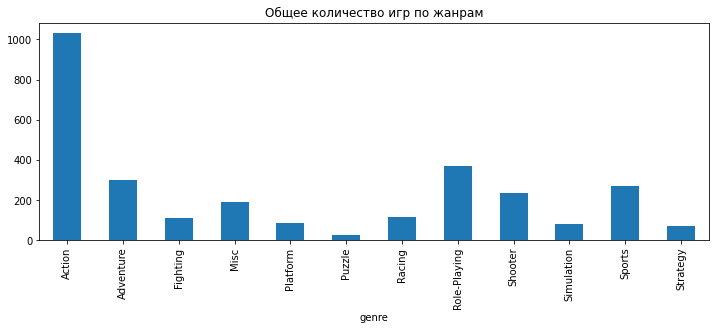

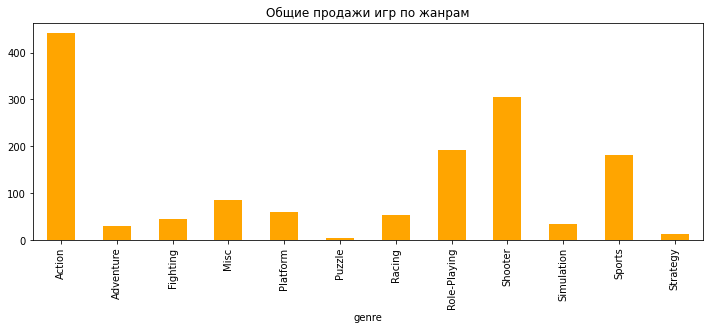

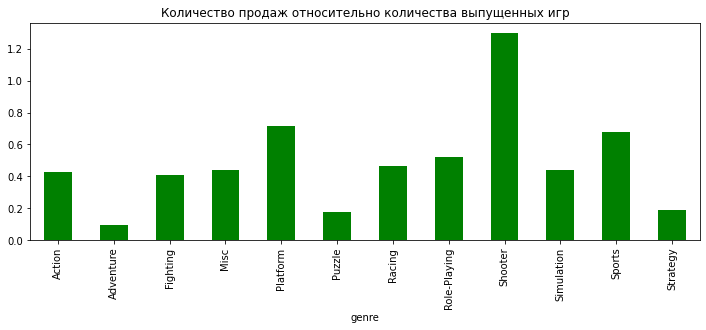

In [19]:
# Диаграмма количества выпущенных игр по жанрам
df_games_actual.\
    pivot_table(index='genre', values='total_sales', aggfunc='count').\
    plot(kind='bar', legend=False, title='Общее количество игр по жанрам', figsize=(12,4))
plt.show()

# Диаграмма общих продаж по жанрам
df_games_actual.\
    pivot_table(index='genre', values='total_sales', aggfunc='sum').\
    plot(kind='bar',color='orange', legend=False, title='Общие продажи игр по жанрам', figsize=(12,4))
plt.show()

# Диаграмма количества продаж относительно количества выпущенных игр
sales_genre_ratio = df_games_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count'])
sales_genre_ratio.columns = ['total_sales_sum', 'count']
sales_genre_ratio['ratio'] = sales_genre_ratio['total_sales_sum'] / sales_genre_ratio['count']
sales_genre_ratio['ratio'].\
    plot(kind='bar', color='green', title='Количество продаж относительно количества выпущенных игр', figsize=(12,4))
plt.show()

Из распределения игр по жанрам видно, что наибольшее количество игр выпускается в жанре Action. Также популярными жанрами являются Role-Playing, Adventure, Sports и Shooter. Наибольшие прожажи приходятся на игры жанров Action, Shooter, Role-Playing, Sports, а наименьшие - Puzzle, Strategy, Adventure, Simulation.  

Немного иная картина открывается, если посмотреть на средние продажи каждой игры в жанре. Здесь лидерами становятся Shooter, Platform и Sports.

### Вывод этапа 3

На данном этапе мы:
- Определили наиболее актуальный период для нашего исследования. В данной работе мы будем работать с данными об играх с 2012 по 2016 годы.
- Определили средний срок жизни популярных платформ - он составляет 10 лет.
- Рассмотрели динамику продаж игр по платформам с 2012 по 2016 годы. Из всех актуальных платформ позитивная динамика продаж только у двух - PS4 и XOne, из чего можно сделать вывод, что эти платформы можно считать перспективными. К тому же они еще далеки от завершения 10 летнего цикла средней жизни платформ.
- Увидели, что продажи по разным платформам значительно различиются, однако средние продажи по платформам различаются значительно меньше.
- Обнаружили, что корреляция между отзывами игроков и продажами практически отсутствует и что корреляция между отзывами критиков и продажами говорит о наличии слабой связи.
- Определили, что наибольшие продажи приходятся на игры жанров Action, Shooter, Role-Playing, Sports, а наименьшие - Puzzle, Strategy, Adventure, Simulation.

## Этап 4. Портрет пользователя каждого региона

**Самые популярные платформы в регионах NA, EU и JP**

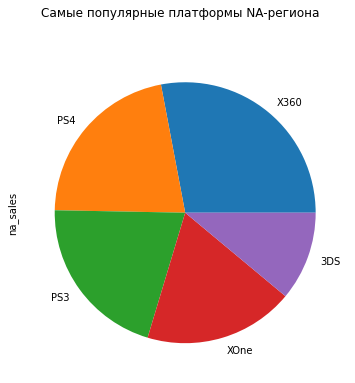

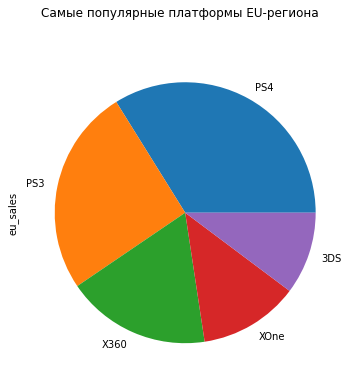

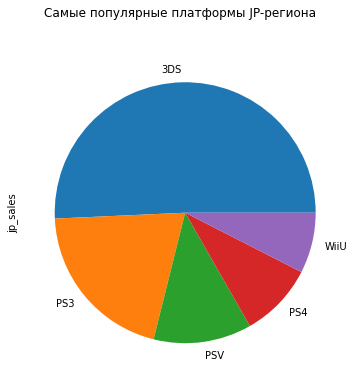

In [20]:
# Диаграмма 5 самых популярных платформ NA-региона
df_games_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').\
    sort_values('na_sales', ascending=False).\
    head().\
    plot(kind='pie', subplots=True, legend=False, title='Самые популярные платформы NA-региона', figsize=(6,6))

# Диаграмма 5 самых популярных платформ EU-региона
df_games_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').\
    sort_values('eu_sales', ascending=False).\
    head().\
    plot(kind='pie', subplots=True, legend=False, title='Самые популярные платформы EU-региона', figsize=(6,6))

# Диаграмма 5 самых популярных платформ JP-региона
df_games_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').\
    sort_values('jp_sales', ascending=False).\
    head().\
    plot(kind='pie', subplots=True, legend=False, title='Самые популярные платформы JP-региона', figsize=(6,6))
plt.show()

Как мы видим из диаграмм выше популярные платформы для регионов NA и EU одинаковы: PS4, PS3, XOne, X360, 3DS. Несколько различается только процент их распределения (XOne и X360 более популярны в NA, а PS4 и PS3 в EU). Несколько иная картина в JP-регионе: половина всех продаж приходится на платформу 3DS, остальную долю делят платформы PS3, PSV, PS4, WiiU.


**Самые популярные жанры в регионах NA, EU и JP**

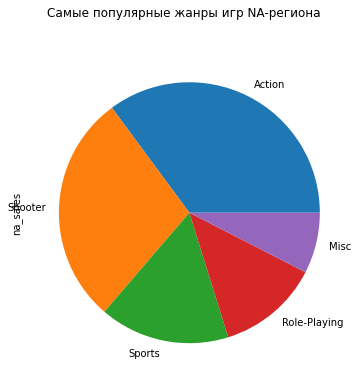

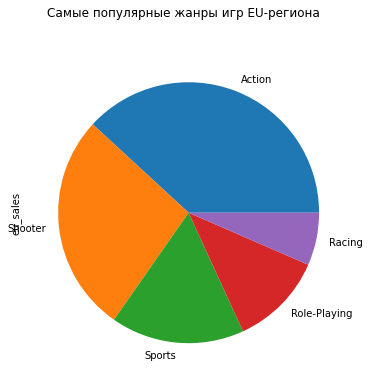

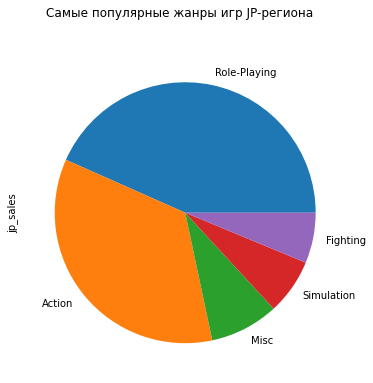

In [21]:
# Диаграмма 5 самых популярных жанров NA-региона
df_games_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').\
    sort_values('na_sales', ascending=False).\
    head().\
    plot(kind='pie', subplots=True, legend=False, title='Самые популярные жанры игр NA-региона', figsize=(6,6))
plt.show()

# Диаграмма 5 самых популярных жанров EU-региона
df_games_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').\
    sort_values('eu_sales', ascending=False).\
    head().\
    plot(kind='pie', subplots=True, legend=False, title='Самые популярные жанры игр EU-региона', figsize=(6,6))
plt.show()

# Диаграмма 5 самых популярных жанров JP-региона
df_games_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').\
    sort_values('jp_sales', ascending=False).\
    head().\
    plot(kind='pie', subplots=True, legend=False, title='Самые популярные жанры игр JP-региона', figsize=(6,6))
plt.show()

Популярные жанры у регионов NA и EU также схожи. Лидирующие позиции в этих регионах занимыют игры жанров Action, Shooter, Spors, Role-Playing. Eдинственным отличием в их рейтингах является то, что в NA-регионе 5 место по популярности занимает жанр Misc, а в EU-регионе жанр Racing. В данном сравнении JP-регион также имеет существенные отличия от других регионов. Наиболее популярными жанрами тут являются Role-Playing, Action, Misc, Simulation, Fighting. При этом популярные в регионах NA и EU Shooter и Sports в JP-регионе не попали в рейтинг, а у жанра Role-Playing имеется значительно большая доля продаж.

**Исследование зависимости продаж от рейтинга ESRB**

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. ESRB была основана в 1994 году.

Рейтинг игр ESRB:
- «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше; такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первой игрой, которая получила данный рейтинг, стала The Simpsons Cartoon Studio, выпущенная в 1996 году. Первоначально "K-A" ("Kids to Adults")
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года. Первой игрой, которая получила данный рейтинг, стала Donkey Kong: Jungle Beat.
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

Источник - Википедия

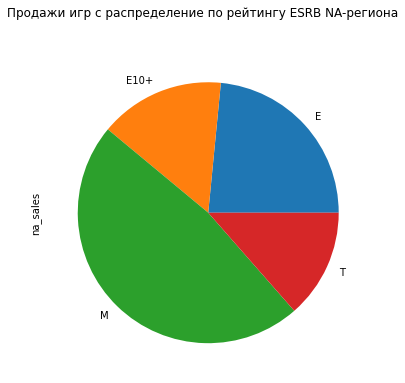

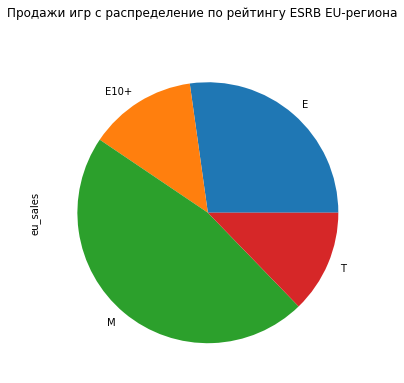

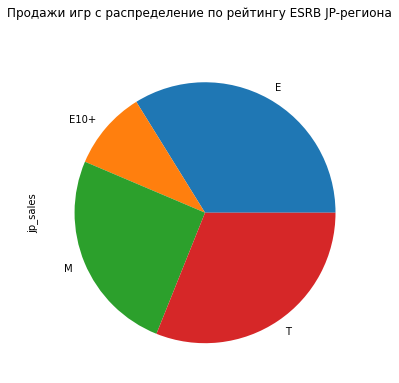

In [22]:
# Диаграмма долей продаж по рейтигу ESRB NA-региона
df_games_actual.\
    pivot_table(index='rating', values='na_sales', aggfunc='sum').\
    plot(kind='pie', subplots=True, legend=False,\
        title='Продажи игр с распределение по рейтингу ESRB NA-региона', figsize=(6,6))
plt.show()

# Диаграмма долей продаж по рейтигу ESRB EU-региона
df_games_actual.\
    pivot_table(index='rating', values='eu_sales', aggfunc='sum').\
    plot(kind='pie', subplots=True, legend=False,\
        title='Продажи игр с распределение по рейтингу ESRB EU-региона', figsize=(6,6))
plt.show()

# Диаграмма долей продаж по рейтигу ESRB JP-региона
df_games_actual.\
    pivot_table(index='rating', values='jp_sales', aggfunc='sum').\
    plot(kind='pie', subplots=True, legend=False,\
        title='Продажи игр с распределение по рейтингу ESRB JP-региона', figsize=(6,6))
plt.show()

Из построенных диаграмм видно, что рейтинг ESRB влияет на продажи в разных регионах. Так наиболее значительная доля продаж в регионах NA и EU приходится на игры с рейтингом "M", далее идут игры с рейтингами "E", "T" и "E10+". В JP-регионе первые места по продажам делят игры с рейтингами "E" и "T", а игры с рейтингом "M" занимают по популярности только третье место.

### Вывод этапа 4

На данном этапе нами было проведено сравнение предпочтений пользователей из разных регионов.
Было установлено, что:
- Популярные платформы для регионов NA и EU одинаковы: PS4, PS3, XOne, X360, 3DS. Несколько различается только процент их распределения (XOne и X360 более популярны в NA, а PS4 и PS3 в EU). Картина в JP-регионе иная: половина всех продаж приходится на платформу 3DS, остальную долю делят платформы PS3, PSV, PS4, WiiU.
- Популярные жанры у регионов NA и EU также схожи. Лидирующие позиции в этих регионах занимают игры жанров Action, Shooter, Spors, Role-Playing. Eдинственным отличием в их рейтингах является то, что в NA-регионе 5 место по популярности занимает жанр Misc, а в EU-регионе жанр Racing. В данном сравнении JP-регион также имеет существенные отличия от других регионов. Наиболее популярными жанрами тут являются Role-Playing, Action, Misc, Simulation, Fighting. При этом популярные в регионах NA и EU Shooter и Sports в JP-регионе не попали в рейтинг, а у жанра Role-Playing имеется значительно большая доля продаж.
- Рейтинг ESRB влияет на продажи в разных регионах. Так наиболее значительная доля продаж в регионах NA и EU приходится на игры с рейтингом "M", далее идут игры с рейтингами "E", "T" и "E10+". В JP-регионе первые места по продажам делят игры с рейтингами "E" и "T", а игры с рейтингом "M" занимают по популярности только третье место.

## Этап 5. Проверка гипотез

Проверим следующие гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковы;
- Средние пользовательские рейтинги жанров Action и Sports одинаковы.

**Проверка гипотезы о рейтингах платформ Xbox One и PC**

Проверим следующую Нулевую гипотезу: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковы".  
Альтернативная теория: "Средние пользовательские рейтинги платформ Xbox One и PC различаются".

In [23]:
# Датафрейм с играми на платформе XOne
xone = df_games_actual.\
    query('platform == "XOne"').\
    dropna(subset=['user_score'])   # Удаление строк с отсутствующими значениями столбца 'user_score'

# Датафрейм с играми на платформе PC
pc = df_games_actual.\
    query('platform == "PC"').\
    dropna(subset=['user_score'])   # Удаление строк с отсутствующими значениями столбца 'user_score'

alpha = 0.05   # Значение alpha берем стандартное - 5%

results = st.ttest_ind(
    xone['user_score'], 
    pc['user_score'],
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую теорию "Средние пользовательские рейтинги платформ Xbox One и PC одинаковы".

**Проверка гипотезы о рейтингах жанров Action и Sports**

Проверим следующую Нулевую гипотезу: "Средние пользовательские рейтинги жанров Action и Sports одинаковы".  
Альтернативная теория: "Средние пользовательские рейтинги жанров Action и Sports различаются".

In [24]:
# Датафрейм с играми жанра Action
action = df_games_actual.\
    query('genre == "Action"').\
    dropna(subset=['user_score'])   # Удаление строк с отсутствующими значениями столбца 'user_score'

# Датафрейм с играми жанра Sports
sports = df_games_actual.\
    query('genre == "Sports"').\
    dropna(subset=['user_score'])   # Удаление строк с отсутствующими значениями столбца 'user_score'

alpha = 0.05   # Значение alpha берем стандартное - 5%

results = st.ttest_ind(
    action['user_score'],
    sports['user_score'],
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Отвергаем нулевую теорию "Средние пользовательские рейтинги жанров Action и Sports одинаковы", следовательно будем придерживаться альтернативной гипотезы "Средние пользовательские рейтинги жанров Action и Sports различаются".

### Вывод этапа 5

На данном этапе нами были проверены следующие гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковы;
- Средние пользовательские рейтинги жанров Action и Sports одинаковы.

Для формулирования нулевой теории нам необходимо поставить условие равенства между проверяемыми выборками, следовательно альтернативная теория будет являться ее противоположностью - будет указывать на разность проверяемых выборок.

Для проверки гипотез мы применили t-критерий Стьюдента для оценки статистической значимости разности двух выборочных средних. Проверка гипотез нами основана на относительно небольших выборках.

Согласно проведенному исследованию:
- Не получилось отвергнуть нулевую теорию "Средние пользовательские рейтинги платформ Xbox One и PC одинаковы".
- Отвергаем нулевую теорию "Средние пользовательские рейтинги жанров Action и Sports одинаковы", следовательно будем придерживаться альтернативной гипотезы "Средние пользовательские рейтинги жанров Action и Sports различаются".


## Этап 6. Общий вывод

В данном исследовании нами былы проанализировады данные о продажах игр на разных платформах и по регионам.

Нами был проведен исследовательский анализ данных:
- Определен наиболее актуальный период для нашего исследования. Таковым является период с 2012 по 2016 годы.
- Рассмотрена динамика продаж игр по платформам с 2012 по 2016 годы. Было обнаружено, что из всех актуальных платформ позитивная динамика продаж только у двух - PS4 и XOne.
- Определено, что продажи игр по разным платформам значительно различиются, однако средние продажи по платформам различаются значительно меньше.
- Обнаружено, что корреляция между отзывами игроков и продажами практически отсутствует и что корреляция между отзывами критиков и продажами говорит о наличии слабой связи.
- Определено, что наибольшие прожажи приходятся на игры жанров Action, Shooter, Role-Playing, Sports, а наименьшие - Puzzle, Strategy, Adventure, Simulation.

Рассмотрено различие в поведении покупателей игр в регионах NA, EU и JP. Было установлено, что:
- Популярные платформы для регионов NA и EU одинаковы: PS4, PS3, XOne, X360, 3DS. Несколько различается только процент их распределения (XOne и X360 более популярны в NA, а PS4 и PS3 в EU). Картина в JP-регионе иная: половина всех продаж приходится на платформу 3DS, остальную долю делят платформы PS3, PSV, PS4, WiiU.
- Популярные жанры у регионов NA и EU также схожи. Лидирующие позиции в этих регионах занимыют игры жанров Action, Shooter, Spors, Role-Playing. Eдинственным отличием в их рейтингах является то, что в NA-регионе 5 место по популярности занимает жанр Misc, а в EU-регионе жанр Racing. В данном сравнении JP-регион также имеет существенные отличия от других регионов. Наиболее популярными жанрами тут являются Role-Playing, Action, Misc, Simulation, Fighting. При этом популярные в регионах NA и EU Shooter и Sports в JP-регионе не попали в рейтинг, а у жанра Role-Playing имеется значительно большая доля продаж.
- Рейтинг ESRB влияет на продажи в разных регионах. Так наиболее значительная доля продаж в регионах NA и EU приходится на игры с рейтингом "M", далее идут игры с рейтингами "E", "T" и "E10+". В JP-регионе первые места по продажам делят игры с рейтингами "E" и "T", а игры с рейтингом "M" занимают по популярности только третье место.

Проверены следующие гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковы. У нас не получилось отвергнуть данную теорию.
- Средние пользовательские рейтинги жанров Action и Sports одинаковы. Отвергли данную теорию. Альтернативная теория - "Средние пользовательские рейтинги жанров Action и Sports различаются".